In [1]:
import os
import numpy as np
import pandas as pd
import xarray as xr
import altair as alt
alt.data_transformers.disable_max_rows()
alt.display.renderers.enable('svg')
import matplotlib.pyplot as plt

import act
import act.discovery, act.io

import metpy.calc, metpy.constants
from metpy.units import units
import glob
from tqdm import tqdm
from sublimpy import utils

In [2]:
startdate = "2022-11-30"
enddate = "2023-06-20"

In [3]:
data_dir = "/Users/elischwat/Development/data/sublimationofsnow/"
# for SAIL data queries
username = os.getenv("ARM_USERNAME")
token = os.getenv("ARM_TOKEN")
DATE_FORMAT_STR = '%Y-%m-%d'

# Retrieve Observations

## SOS towers

In [4]:
sos_fn = '../paper1/process_slow_data/tidy_df_20221101_20230619_planar_fit_multiplane_q7_flags9000_pf10.parquet'
sos_df = pd.read_parquet(sos_fn)

## Doppler lidar mean winds (PPI/VAD)

In [5]:
SAIL_DATA_STREAM = 'gucdlprofwind4newsM1.c1'
DATA_STREAM_FILEEXT = '.nc'
output_dir = os.path.join("/Users/elischwat/Development/data/sublimationofsnow/", SAIL_DATA_STREAM)

In [6]:
# act.discovery.download_arm_data(USERNAME, TOKEN, SAIL_DATA_STREAM, startdate, enddate, output=output_dir)

In [7]:
dl_w_prof_files = glob.glob("/Users/elischwat/Development/data/sublimationofsnow/gucdlprofwind4newsM1.c1/*.nc")

In [8]:
prof_ds = act.io.read_arm_netcdf(dl_w_prof_files)
prof_ds.time.min(), prof_ds.time.max()

(<xarray.DataArray 'time' ()> Size: 8B
 array('2022-11-30T00:00:39.646250000', dtype='datetime64[ns]'),
 <xarray.DataArray 'time' ()> Size: 8B
 array('2023-06-15T23:59:20.789108000', dtype='datetime64[ns]'))

In [9]:
prof_df = prof_ds.to_dataframe()
prof_df = utils.modify_df_timezone(prof_df.reset_index(), 'UTC', 'US/Mountain').set_index('time')

In [10]:
synoptic_winds_30min = prof_df.query("height > 900").query("height < 2000")[['wind_speed', 'wind_direction']].reset_index().set_index('time').groupby(pd.Grouper(freq='30min')).mean().ffill()

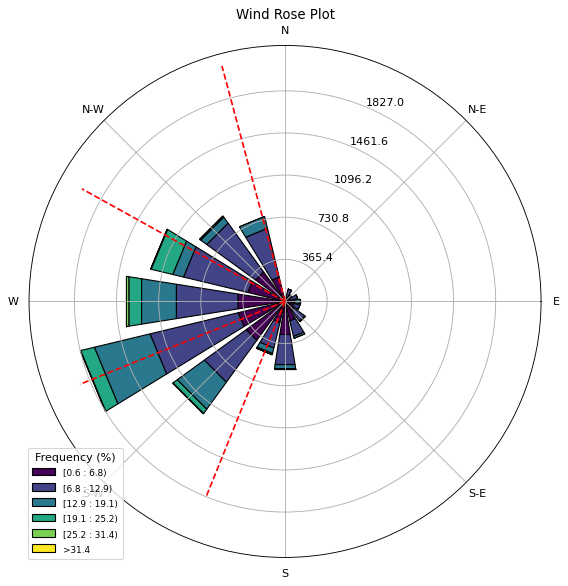

In [11]:
import matplotlib.pyplot as plt
from windrose import WindroseAxes
import numpy as np


# Create a wind rose plot
ax = WindroseAxes.from_ax()
ax.bar(synoptic_winds_30min['wind_direction'], synoptic_winds_30min['wind_speed'], edgecolor='black')

# Add a line at theta = 299 degrees
# theta = np.deg2rad(-299 + 90)  # Convert degrees to radians
ax.plot([np.deg2rad(-202 + 90), np.deg2rad(-202 + 90)], [0, ax.get_rmax()], color='red', linestyle='--', label='Theta = 299°')
ax.plot([np.deg2rad(-248 + 90), np.deg2rad(-248 + 90)], [0, ax.get_rmax()], color='red', linestyle='--', label='Theta = 299°')

ax.plot([np.deg2rad(-299 + 90), np.deg2rad(-299 + 90)], [0, ax.get_rmax()], color='red', linestyle='--', label='Theta = 299°')
ax.plot([np.deg2rad(-345 + 90), np.deg2rad(-345 + 90)], [0, ax.get_rmax()], color='red', linestyle='--', label='Theta = 299°')

# Customize the plot
ax.set_title("Wind Rose Plot")
ax.set_legend(title="Frequency (%)")
plt.show()

<Axes: ylabel='Frequency'>

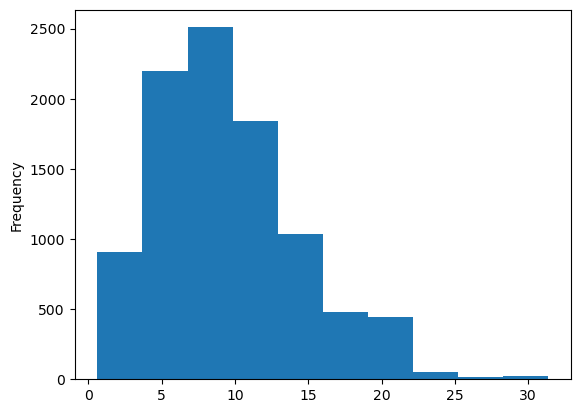

In [12]:
synoptic_winds_30min.wind_speed.plot.hist()

In [13]:
winds_ge10_times = synoptic_winds_30min [ synoptic_winds_30min.wind_speed > 10 ] 
winds_le10_times = synoptic_winds_30min [ synoptic_winds_30min.wind_speed <= 10 ] 

In [14]:
along_valley_wind_times = synoptic_winds_30min[
    (synoptic_winds_30min.wind_direction > 299)
    & (synoptic_winds_30min.wind_direction < 345 )
].index.values
cross_valley_wind_times = synoptic_winds_30min[
    (synoptic_winds_30min.wind_direction > 202)
    & (synoptic_winds_30min.wind_direction < 270 )
].index.values
len(cross_valley_wind_times), len(along_valley_wind_times)

(3942, 2044)

## Doppler Lidar Vertical Velocity Variance

In [15]:
# Inputs
username = os.getenv("ARM_USERNAME")
token = os.getenv("ARM_TOKEN")
DATE_FORMAT_STR = '%Y-%m-%d'
DLW_DATA_STREAM = 'gucdlprofwstats4newsM1.c1'
DLW_DATA_STREAM_FILEEXT = '.cdf'
DLW_OUTPUT_DIR = os.path.join(data_dir, DLW_DATA_STREAM)

In [16]:
file_list = act.discovery.download_arm_data(
    username, token, DLW_DATA_STREAM, startdate, enddate, output = DLW_OUTPUT_DIR
)

[DOWNLOADING] gucdlprofwstats4newsM1.c1.20230514.000000.nc
[DOWNLOADING] gucdlprofwstats4newsM1.c1.20230225.000000.nc
[DOWNLOADING] gucdlprofwstats4newsM1.c1.20230508.000000.nc
[DOWNLOADING] gucdlprofwstats4newsM1.c1.20230607.000000.nc
[DOWNLOADING] gucdlprofwstats4newsM1.c1.20230311.000000.nc
[DOWNLOADING] gucdlprofwstats4newsM1.c1.20230430.000000.nc
[DOWNLOADING] gucdlprofwstats4newsM1.c1.20230223.000000.nc
[DOWNLOADING] gucdlprofwstats4newsM1.c1.20230509.000000.nc
[DOWNLOADING] gucdlprofwstats4newsM1.c1.20230122.000000.nc
[DOWNLOADING] gucdlprofwstats4newsM1.c1.20221222.000000.nc
[DOWNLOADING] gucdlprofwstats4newsM1.c1.20221202.000000.nc
[DOWNLOADING] gucdlprofwstats4newsM1.c1.20221223.000000.nc
[DOWNLOADING] gucdlprofwstats4newsM1.c1.20230226.000000.nc
[DOWNLOADING] gucdlprofwstats4newsM1.c1.20230317.000000.nc
[DOWNLOADING] gucdlprofwstats4newsM1.c1.20230213.000000.nc
[DOWNLOADING] gucdlprofwstats4newsM1.c1.20230411.000000.nc
[DOWNLOADING] gucdlprofwstats4newsM1.c1.20230429.000000.

In [17]:
dl_wstats = xr.open_mfdataset(file_list)
dl_wstats = utils.modify_xarray_timezone(
    dl_wstats,
    'UTC',
    'US/Mountain'
)

In [18]:
df_wstats = dl_wstats[['w_variance', 'w_skewness']].to_dataframe()

In [19]:
df_wstats_30min = df_wstats.reset_index().set_index('time').groupby([pd.Grouper(freq='30min'), 'height']).mean().reset_index()
df_wstats_30min


,time,height,w_variance,w_skewness,time (US/Mountain),time (UTC)
0,2022-11-29 17:00:00,15.0,0.000234,-0.379480,2022-11-29 17:10:00,2022-11-30 00:10:00
1,2022-11-29 17:00:00,45.0,1.077502,-0.319172,2022-11-29 17:10:00,2022-11-30 00:10:00
2,2022-11-29 17:00:00,75.0,0.555193,-0.303367,2022-11-29 17:10:00,2022-11-30 00:10:00
3,2022-11-29 17:00:00,105.0,0.693679,-0.316026,2022-11-29 17:10:00,2022-11-30 00:10:00
4,2022-11-29 17:00:00,135.0,0.888906,-0.538809,2022-11-29 17:10:00,2022-11-30 00:10:00
...,...,...,...,...,...,...
1270411,2023-06-16 17:30:00,3855.0,NaN,NaN,2023-06-16 17:40:00,2023-06-16 23:40:00
1270412,2023-06-16 17:30:00,3885.0,NaN,NaN,2023-06-16 17:40:00,2023-06-16 23:40:00
1270413,2023-06-16 17:30:00,3915.0,NaN,NaN,2023-06-16 17:40:00,2023-06-16 23:40:00
1270414,2023-06-16 17:30:00,3945.0,NaN,NaN,2023-06-16 17:40:00,2023-06-16 23:40:00


In [20]:
df_wstats_along_valley = df_wstats_30min[df_wstats_30min.time.isin(along_valley_wind_times)].query("height < 2000").assign(synoptic_wind_direction = 'along-valley')
df_wstats_cross_valley = df_wstats_30min[df_wstats_30min.time.isin(cross_valley_wind_times)].query("height < 2000").assign(synoptic_wind_direction = 'cross-valley')

df_wstats_with_synoptic_conditions = pd.concat([
    df_wstats_along_valley[df_wstats_along_valley.time.isin(winds_ge10_times.index)].assign(synoptic_wind_speed = '> 10'),
    df_wstats_along_valley[df_wstats_along_valley.time.isin(winds_le10_times.index)].assign(synoptic_wind_speed = '<= 10'),
    df_wstats_cross_valley[df_wstats_cross_valley.time.isin(winds_ge10_times.index)].assign(synoptic_wind_speed = '> 10'),
    df_wstats_cross_valley[df_wstats_cross_valley.time.isin(winds_le10_times.index)].assign(synoptic_wind_speed = '<= 10')
])

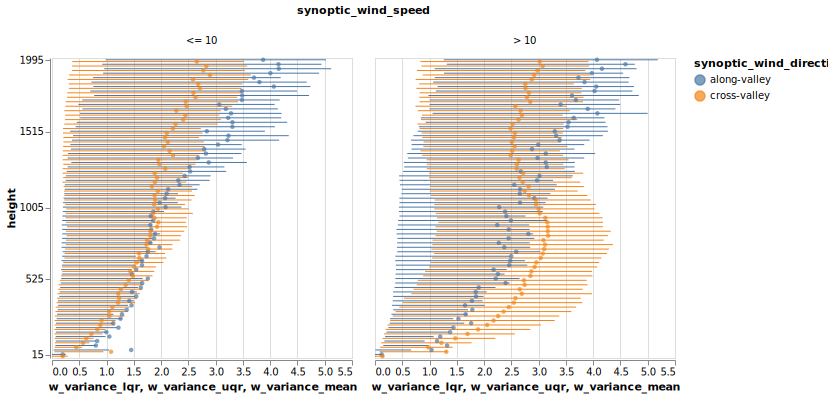

In [21]:
df_wvariance_stats = pd.concat([
    df_wstats_with_synoptic_conditions.groupby(['height', 'synoptic_wind_direction', 'synoptic_wind_speed'])['w_variance'].quantile(0.25).rename('w_variance_lqr'),
    df_wstats_with_synoptic_conditions.groupby(['height', 'synoptic_wind_direction', 'synoptic_wind_speed'])['w_variance'].quantile(0.75).rename('w_variance_uqr'),
    df_wstats_with_synoptic_conditions.groupby(['height', 'synoptic_wind_direction', 'synoptic_wind_speed'])['w_variance'].mean().rename('w_variance_mean'),
], axis=1).reset_index()

(alt.Chart(df_wvariance_stats).mark_rule().encode(
    alt.X('w_variance_lqr:Q'),
    alt.X2('w_variance_uqr:Q'),
    alt.Y('height:O').scale(reverse=True).axis(values=[15,525, 1005, 1515,1995]),
    alt.YOffset('synoptic_wind_direction:N'),
    alt.Color('synoptic_wind_direction'),
).properties(height=300) + alt.Chart(df_wvariance_stats).mark_circle(size=20).encode(
    alt.X('w_variance_mean:Q'),
    alt.Y('height:O').scale(reverse=True).axis(values=[15,525, 1005, 1515,1995]),
    alt.YOffset('synoptic_wind_direction:N'),
    alt.Color('synoptic_wind_direction'),
).properties(height=300)).facet(
    column = 'synoptic_wind_speed'
)

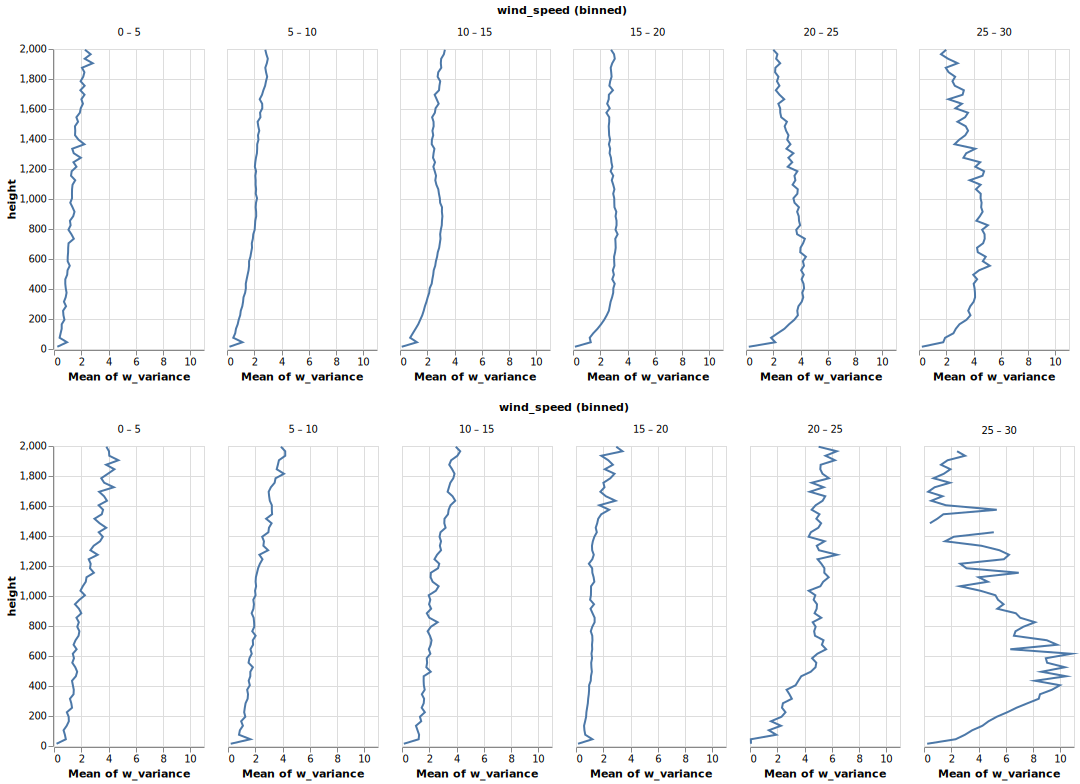

In [22]:
(alt.Chart(
    df_wstats_cross_valley.set_index('time').join(synoptic_winds_30min)
).mark_line().encode(
    alt.X('mean(w_variance)'),
    alt.Y('height:Q'),
    alt.Facet('wind_speed').bin(),
    order='height'
).properties(width=150) & alt.Chart(
    df_wstats_along_valley.set_index('time').join(synoptic_winds_30min)
).mark_line().encode(
    alt.X('mean(w_variance)'),
    alt.Y('height:Q'),
    alt.Facet('wind_speed').bin(),
    order='height'
).properties(width=150)).resolve_scale(y='shared', x='shared')

# Compare wind direction shear and mixing intensity

In [89]:
wprof_resampled_ds = prof_df.groupby([pd.Grouper(freq='30min'), 'height'])[['wind_speed', 'wind_direction']].mean().to_xarray()

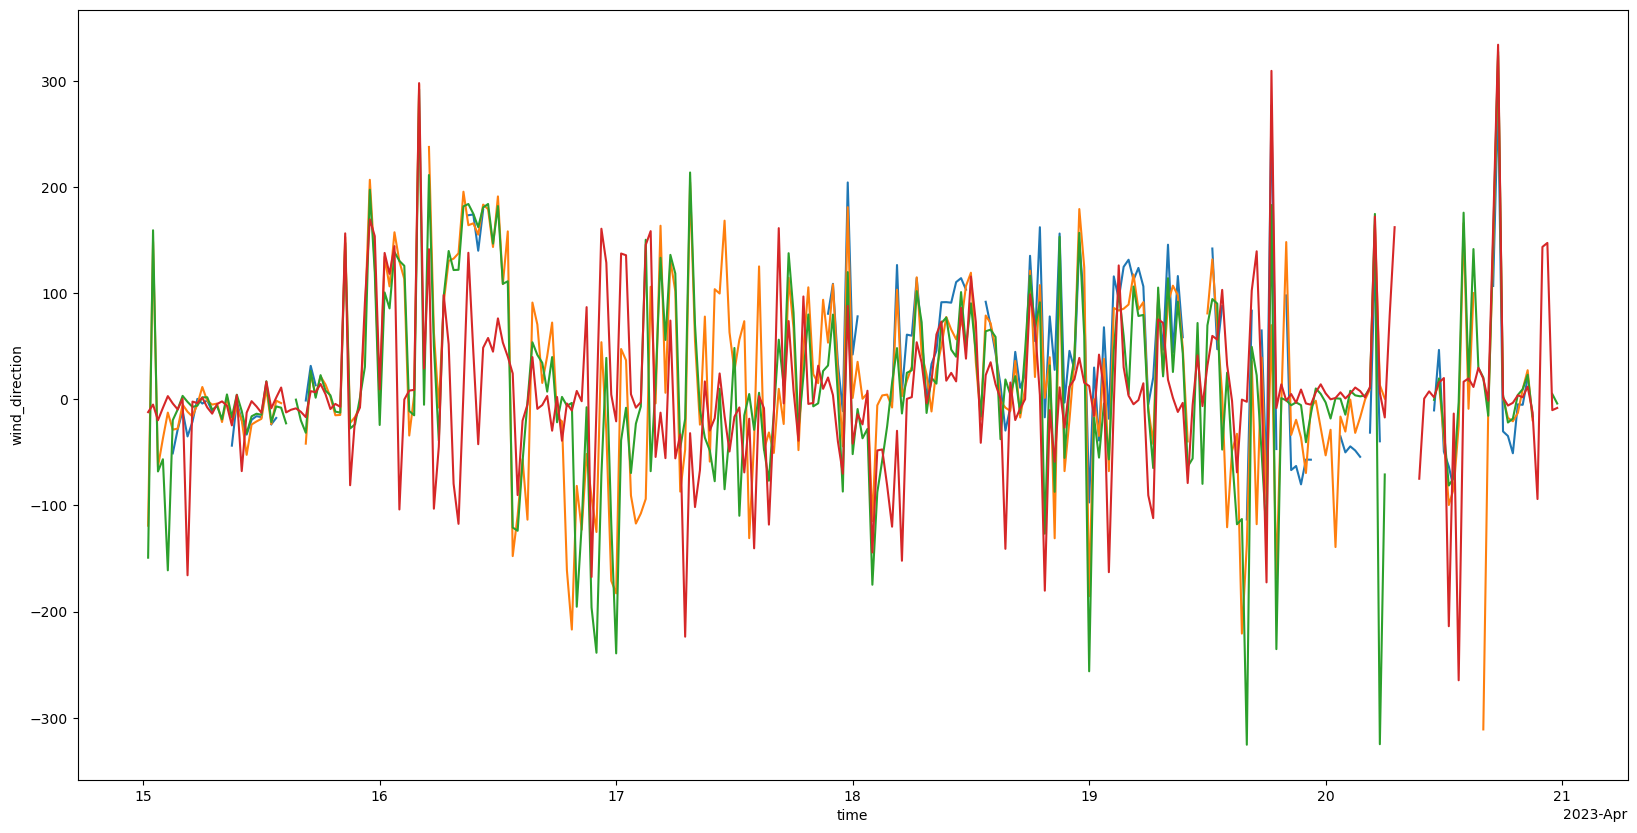

In [100]:
winddir_delta_100_1200  = wprof_resampled_ds.interp(height=1200)['wind_direction'] - wprof_resampled_ds.interp(height=100)['wind_direction']
winddir_delta_100_600   = wprof_resampled_ds.interp(height=600)['wind_direction'] - wprof_resampled_ds.interp(height=100)['wind_direction']
winddir_delta_100_400   = wprof_resampled_ds.interp(height=400)['wind_direction'] - wprof_resampled_ds.interp(height=100)['wind_direction']
winddir_delta_100_200   = wprof_resampled_ds.interp(height=200)['wind_direction'] - wprof_resampled_ds.interp(height=100)['wind_direction']

plt.figure(figsize=(20,10))
winddir_delta_100_1200.loc['20230415':'20230420'].plot()
winddir_delta_100_600.loc['20230415':'20230420'].plot()
winddir_delta_100_400.loc['20230415':'20230420'].plot()
winddir_delta_100_200.loc['20230415':'20230420'].plot()

In [101]:
wstats_resampled_ds = df_wstats.reset_index().set_index('time').groupby([pd.Grouper(freq='30min'), 'height']).mean()[['w_variance', 'w_skewness']].to_xarray()

wstats_resampled_ds

<xarray.Dataset> Size: 10MB
Dimensions:     (time: 9552, height: 133)
Coordinates:
  * time        (time) datetime64[ns] 76kB 2022-11-29T17:00:00 ... 2023-06-16...
  * height      (height) float32 532B 15.0 45.0 75.0 ... 3.945e+03 3.975e+03
Data variables:
    w_variance  (time, height) float32 5MB 0.0002338 1.078 0.5552 ... nan nan
    w_skewness  (time, height) float32 5MB -0.3795 -0.3192 -0.3034 ... nan nan